In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis

In this analysis I will be looking to answer the question what attributes, that differ from the general population of music, are typical of songs taken from a subset of playlists.

-----------------
$H_o$: The attributes of songs in specified playlists are no different than the general population.

$H_a$: The attributes of songs in specified playlists are measurably different than the general population

--------------

First, I will be covering songs found in 'running' playlists. Then, I will do a similar analysis with songs found in 'study' playlists. The attributes covered will include tempo, valence (mood), instrumentalness, energy, acousticness and speechiness. I will explain what each of those mean as we go on but you can find explanations [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from non_param_effect_size import calc_non_param_ci, cles_ind, rbc_ind

%matplotlib inline


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#initialize colors to be used for visualizations


### Run, Run, Run

First, I would like to outline some base assumptions we might have about how a 'running' song may differ from the crowd. I personally am not a runner but if I were to create a running playlist, these are some of the attributes I would look for:
- [ ] Fast
- [ ] Energetic
- [ ] Uplifting

Fast to push my pace. Energetic to pump me up. And uplifting to escape from the pain.

In [8]:
running = pd.read_csv("../data/running_playlist_tracks.csv")
running.drop(columns="Unnamed: 0", inplace=True)
gen = pd.read_csv("../data/sampled_set.csv")
gen.drop(columns="Unnamed: 0", inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Up the Tempo

The internal clock of a song is measured in BPM or beats per minute. The higher the BPM. the faster the song. The hypotheses:

$H_o$: The average tempo of running playlist songs is the *same* as the general population

$H_a$: The average tempo of running playlist songs is *higher* than the general population

Let's start by just looking at the distributions:

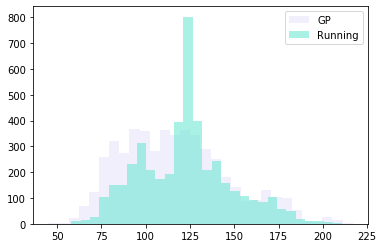

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Get rid of zeros because they represent either incomplete or erroneous data.
gen_filtered = gen[gen["tempo"] != 0]
run_filtered = running[running["tempo"] != 0]
gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color="#e6e0fd")
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color="#56e5cc")
plt.legend()
plt.grid(b=None)
plt.show()